In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt




In [2]:
# === 1. Load and Clean Data ===
data = pd.read_csv('Base.csv')  # Replace with your path

In [3]:
#replace -1 and pd.NA = np.nan # standard the Nan
data = data.replace(-1, np.nan)
data = data.astype(object).where(pd.notna(data), np.nan) 


In [4]:
Y = data['fraud_bool']  
X = data.drop(columns=['fraud_bool'])

In [9]:
data['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

In [11]:
Y = data['fraud_bool'].astype(int)# int 

In [13]:
#automatically identify numerical and categorical columns.
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [15]:
#For all numeric columns, first fill in missing values using the mean, then scale them using standardization.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [17]:
#For all categorical columns, first fill in missing values with the most frequent category, 
#then convert the categories to one-hot encoded columns so machine learning models can use them.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
#For the numeric columns, apply this transformation.
#For the categorical columns, apply a different transformation.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])



In [21]:
# === 4. Build full pipeline with RBF approximation ===
rbf_feature = RBFSampler(gamma=0.1, n_components=500, random_state=1)
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, class_weight='balanced')

In [23]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('rbf', rbf_feature),
    ('classifier', sgd_clf)
])

In [25]:
# === 5. Split data and train ===
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)                         
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['income',
                                                   'name_email_similarity',
                                                   'prev_address_months_count',
                                                   'current_ad...
                                                   'phone_home_valid',
                                                   'phone_mobile_valid',
                                                   'bank_months_count',
                                                   'has_other_cards',
                                                   'proposed_credit_limit',
                                                   'foreign_request', 'source',
                                                   'session_length_in_minutes',
                                                   'device_os',
                                                   'keep_alive_session',
                                                   'device_distinct_emails_8w',
                                                   'device_fraud_count', ...])])),
                ('rbf',
                 RBFSampler(gamma=0.1, n_components=500, random_state=1)),
                ('classifier', SGDClassifier(class_weight='balanced'))])

In [27]:


# === 6. Evaluate ===
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    296786
           1       0.03      0.74      0.06      3214

    accuracy                           0.76    300000
   macro avg       0.51      0.75      0.46    300000
weighted avg       0.99      0.76      0.85    300000



In [36]:

# === 8. ROC Curve ===
y_scores = clf.decision_function(X_test)  # Use decision_function for SGDClassifier
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

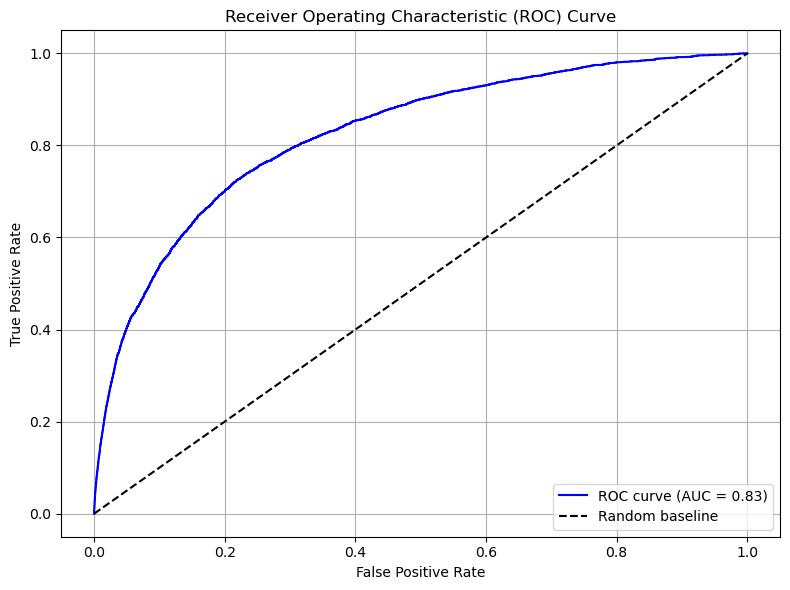

In [42]:
# === 9. Plot ROC Curve ===
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()